In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import h,c,k

In [2]:
hdu2=fits.open('/home/soumadip/Downloads/FIRAS_DESTRIPED_SKY_SPECTRA_LOWF.FITS')
#hdu2=fits.open('/home/soumadip/Downloads/FIRAS_DESTRIPED_SKY_SPECTRA_HRES.FITS')
#hdu2.info()


#### Contents of the dataset

In [3]:
destriped_data=hdu2[1].data
destriped_data.columns

ColDefs(
    name = 'PIXEL'; format = '1J'
    name = 'GAL_LON'; format = '1E'; unit = 'deg'
    name = 'GAL_LAT'; format = '1E'; unit = 'deg'
    name = 'WEIGHT'; format = '1E'
    name = 'STR_USED'; format = '1I'
    name = 'SPECTRUM'; format = '182E'; unit = 'MJy/sr'; dim = '(182)'
)

#### Getting best fit temperatures for every pixel

It is observed that all the pixels only have 43 intensity values. This makes our job much easier

In [4]:
c_cms=100*c
from scipy.optimize import curve_fit
def Intensity(freq,T):
    e=np.exp(h*freq/(k*T))
    return (2*h*freq**3)/(c**2*(e-1))*1e20
    '''
    h = planck constant
    k = boltzmann constant
    c = speed of light in vacuum
    T = temperature of blackbody
    wave_num = wave number of the radiation (1/wavelength)
    '''

In [5]:
destriped_data['SPECTRUM'][0][:43:]

array([200.99837 , 250.11607 , 291.79953 , 327.67313 , 354.35162 ,
       371.71155 , 380.97324 , 382.51492 , 379.22812 , 369.41425 ,
       354.22485 , 336.02118 , 316.01633 , 294.3508  , 272.22424 ,
       249.2363  , 225.75806 , 204.64339 , 183.8708  , 164.61542 ,
       147.0386  , 130.8039  , 115.107666, 100.194725,  87.60677 ,
        75.39579 ,  65.42178 ,  58.212032,  49.86374 ,  44.60809 ,
        38.68048 ,  33.088512,  27.845034,  23.259144,  21.270378,
        18.62001 ,  14.422012,  12.399126,  13.102548,  11.390899,
         8.961309,   8.099037,  15.854761], dtype=float32)

In [6]:
# 1st frequency is 68.020812 Ghz
freq_0=68.020812*1e9
freq_interval=13.604162*1e9
#wave number is freq/c. there are 43 total values measured with this interval

frequency=[]
for i in range(43):
    freq_flag=freq_0+i*freq_interval
    frequency.append(freq_flag)
frequency=np.array(frequency)

In [7]:

def get_Temperature(frequency,input):
    Pixel_data=dict()
    Pixel_data['Temperature']=[]
    Pixel_data['Uncertainty']=[]
    for i in range(len(input)):
        Intensity_observed=input[i]
        Intensity_observed=Intensity_observed[0:43:]
        T0=2
        popt,pcov=curve_fit(Intensity,frequency,Intensity_observed,p0=[T0])
        Temperature_fit=popt[0]
        Uncertainty_fit=np.sqrt(np.diag(pcov))
        Pixel_data['Temperature'].append(Temperature_fit)
        Pixel_data['Uncertainty'].append(Uncertainty_fit)
    return Pixel_data


In [38]:
Pixel_data=get_Temperature(frequency,destriped_data['SPECTRUM'])


In [39]:
avg_temperature=np.sum(Pixel_data['Temperature'])/len(Pixel_data['Temperature'])
avg_uncertainty=np.sum(Pixel_data['Uncertainty'])/len(Pixel_data['Uncertainty'])
print('T = {:.3f} + {:.3f} K'.format(avg_temperature,avg_uncertainty))

T = 2.730 + 0.001 K


In [10]:
avg_temperature

2.729849878262956

This is far from the given value . We need to remove the galactic contamination it seems


In [11]:
longtitude=[]
for i in destriped_data['GAL_LON']:
    if i > 180:
        longtitude.append(i-360)
    else:
        longtitude.append(i)


In [12]:
lattitude_rad=np.pi*destriped_data['GAL_LAT']/180
longtitude_rad=np.pi*np.array(longtitude)/180



In [13]:
#coords=SkyCoord(l=longtitude_rad,b=lattitude_rad)
from matplotlib.colors import LogNorm

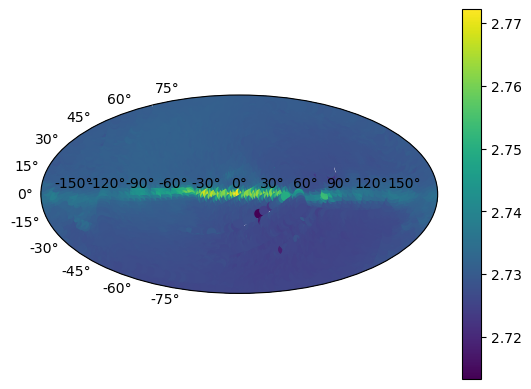

In [14]:
plt.figure()
plt.subplot(111,projection='aitoff')
#plt.scatter(longtitude_rad,lattitude_rad,c=Pixel_data['Temperature'],cmap='plasma',norm=LogNorm(vmax=np.nanmax(Pixel_data['Temperature'])))
plt.scatter(longtitude_rad,lattitude_rad,c=np.array(Pixel_data['Temperature']))
plt.colorbar()

#### Removing 5 $\sigma$ data

In [15]:
def root_mean_square(input):
    input=np.array(input)
    squared_input=input*input
    mean=np.sum(squared_input)/squared_input.size
    return np.sqrt(mean)

root_mean_square(Pixel_data['Temperature'])

2.729853832890406

In [30]:
def standard_deviation(mean,input):
    input=np.array(input)
    difference=input-mean 
    squared=difference**2
    mean_=np.sum(squared)/squared.size
    return np.sqrt(mean_)

#### Removing galactic dust

In [46]:
lowdust_data = fits.open("/home/soumadip/Downloads/FIRAS_DUST_SPECTRUM_MAP_LOWF.FITS")
dust_data = lowdust_data[1].data
final_data = destriped_data['SPECTRUM']-dust_data['SPECTRUM']
Pixel_data=get_Temperature(frequency,final_data[:43:])
avg_temperature=np.mean(Pixel_data['Temperature'])
avg_uncertainty=np.mean(Pixel_data['Uncertainty'])
print('T = {:.4f} + {:.4f} K'.format(avg_temperature,avg_uncertainty))

T = 2.7254 + 0.0002 K


In [51]:
lattitude = destriped_data['GAL_LAT']
longtitude=destriped_data['GAL_LON']
Intensity_observed = destriped_data['SPECTRUM']
#Intensity_observed = final_data
i=[]
accepted_spectrum=[]
accepted_lattitude=[]
accepted_longtitude=[]

for i in range(0,len(lattitude)):
    if lattitude[i] < 10 :
        if lattitude[i] >-10:
            continue
        else:
            accepted_spectrum.append(Intensity_observed[i])
            accepted_lattitude.append(lattitude[i])
            accepted_longtitude.append(longtitude[i])
    if lattitude[i]>10:
        accepted_spectrum.append(Intensity_observed[i])
        accepted_lattitude.append(lattitude[i])
        accepted_longtitude.append(longtitude[i])
spectrum_cut=np.array(accepted_spectrum)
spectrum_cut.shape

(5013, 182)

In [52]:
longtitude=[]
for i in accepted_longtitude:
    if i > 180:
        longtitude.append(i-360)
    else:
        longtitude.append(i)
accepted_lattitude=np.array(accepted_lattitude)
accepted_longtitude=np.array(longtitude)

In [53]:
Pixel_cut = get_Temperature(frequency,spectrum_cut)
avg_temperature=np.sum(Pixel_cut['Temperature'])/len(Pixel_cut['Temperature'])
avg_uncertainty=np.sum(Pixel_cut['Uncertainty'])/len(Pixel_cut['Uncertainty'])
print('T = {:.4f} + {:.4f} K'.format(avg_temperature,avg_uncertainty))

T = 2.7286 + 0.0008 K


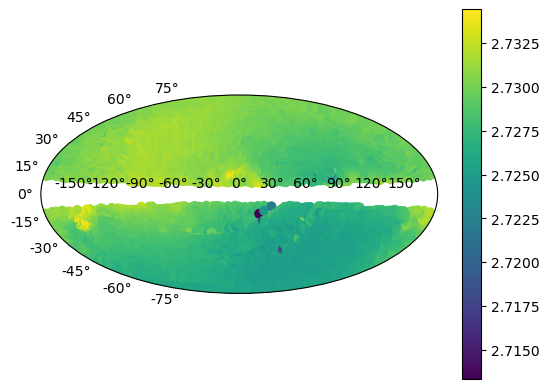

In [21]:
longtitude=[]
for i in accepted_longtitude:
    if i > 180:
        longtitude.append(i-360)
    else:
        longtitude.append(i)
lattitude=accepted_lattitude
lattitude_rad=np.pi*np.array(lattitude)/180
longtitude_rad=np.pi*np.array(longtitude)/180
plt.figure()
plt.subplot(111,projection='aitoff')
plt.scatter(longtitude_rad,lattitude_rad,c=Pixel_cut['Temperature'])
plt.colorbar()

In [31]:
sigma_corrected_data=[]
sigma = standard_deviation(avg_temperature,Pixel_cut['Temperature'])
for i in Pixel_cut['Temperature']:
    point_max=avg_temperature+5*sigma
    point_min=avg_temperature-5*sigma
    if i < point_max:
        if i>=point_min:
            sigma_corrected_data.append(i)
sigma_corrected_data=np.array(sigma_corrected_data)
np.mean(sigma_corrected_data)

2.7286124896212716

In [29]:
np.min(Pixel_cut['Temperature'])

2.7133298470247027

In [27]:
avg_temperature+5*sigma

2.739277217621538

In [23]:
#Code to calculate angle between two given galactic coordinate vectors
import math as mt
def vector(l,b):
  a=mt.radians(l)
  b=mt.radians(b)
  x=mt.cos(a)*mt.cos(b)
  y=mt.sin(a)*mt.cos(b)
  z=mt.sin(b)
  vect=[x,y,z]
  return vect


l1=int(input("Enter first longitude angle in degrees: "))
b1=int(input("Enter first latitude angle in degrees: "))
l2=int(input("Enter second longitude angle in degrees: "))  
b2=int(input("Enter second latitude angle in degrees: "))

def dotprod(A,B):
  x=0
  for i in range(0,len(A)):
    x+=A[i]*B[i]
  return x

magsqrA=0
magsqrB=0
for i in A:
  magsqrA+=i*i
for j in B:
  magsqrB+=j*j

magnitudeA=mt.sqrt(magsqrA)
print(magnitudeA)
magnitudeB=mt.sqrt(magsqrB)
print(magnitudeB)
print(magnitudeA*magnitudeB)

def theta(A,B):
  thetarad=mt.acos(dotprod(A,B)/(magnitudeA*magnitudeB))
  thetadeg=mt.degrees(thetarad)
  return thetarad
A=vector(l1,b1)
B=vector(l2,b2)

theta(A,B)

ValueError: invalid literal for int() with base 10: ''

In [ ]:
def deg_rad(deg):
    rad = np.pi * deg/180
    return rad
def costheta(l1,b1,l2,b2):
    l1=deg_rad(l1)
    b1=deg_rad(b1)
    l2=deg_rad(l2)
    b2=deg_rad(b2)
    a=np.cos(b1)*np.cos(l1)*np.cos(b2)*np.cos(l2)
    b=np.sin(b1)*np.sin(l1)*np.cos(b2)*np.sin(l2)
    c=np.sin(b1)*np.sin(b2)
    return a+b+c

In [ ]:
import math

In [ ]:
math.cos(np.pi/2)

6.123233995736766e-17

In [ ]:
costheta(90,0,0,0)

0.0